Import Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)
    


Get default dataframe from NewLeverage Notebook

In [3]:
%store -r d_default_averageYear

Additional Settings

In [4]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import ticker
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
from matplotlib import cm
import datetime

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

#setting matplotlib style
plt.style.use('default')

#setting params for matplolib plots
plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title
plt.rcParams['xtick.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.size']=3.5  # fontsize of the figure title
#plt.rcParams['xtick.major.width']=1  # fontsize of the figure title
plt.rcParams['xtick.major.top']=False  # fontsize of the figure title
plt.rcParams['xtick.minor.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.minor.size']=3  # fontsize of the figure title
#plt.rcParams['legend.fontsize'] = 22

#setting grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

#figsizes
figsize_OneGraph=(20,10)


Structural adjustments on dataset

In [5]:
#removing investment banks Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

Parse time

In [6]:
df_raw["date"] = pd.to_datetime(df_raw.date, format='%Y%m%d')

Timeseries labels for xaxis 

In [7]:
years = [str(year) for year in range(1976, 2014)]

years16 = [str(year) for year in range(1976, 2014, 4)]

Functions for plotting crisis shades on graph

In [8]:
def plot_crisis(ax):
    #1980Q1-Q3 crisis
    ax.axvspan(16, 19, alpha=0.5, color='gray')


    #1981Q3-1982Q4 crisis
    ax.axvspan(22, 27, alpha=0.5, color='gray')

    #1990Q3-1991Q2 crisis
    ax.axvspan(58, 61, alpha=0.5, color='gray')

    #2001Q2-2001Q4 crisis
    ax.axvspan(101, 103, alpha=0.5, color='gray')

    #2007Q4-2009Q3 crisis
    ax.axvspan(127, 134, alpha=0.5, color='gray')


In [9]:
'''
Takes xaxis with datetime objects
'''
def plot_crisis_datetime(ax):
    #1980 crisis
    ax.axvspan(datetime.datetime(1980,3,31), datetime.datetime(1980,9,30), alpha=0.5, color='gray')
    
    
    #1981Q3-1982Q4 crisis
    ax.axvspan(datetime.datetime(1981,9,30), datetime.datetime(1982,12,31), alpha=0.5, color='gray')
    
    #1990Q3-1991Q2 crisis
    ax.axvspan(datetime.datetime(1990,9,30), datetime.datetime(1991,6,30), alpha=0.5, color='gray')
    
    #2001Q2-2001Q4 crisis
    ax.axvspan(datetime.datetime(2001,6,30), datetime.datetime(2001,12,31), alpha=0.5, color='gray')
    
    #2007Q4-2009Q3 crisis
    ax.axvspan(datetime.datetime(2007,12,31), datetime.datetime(2009,9,30), alpha=0.5, color='gray')

Make ax-settings

In [10]:
def axsetting(ax):
    ax.set_xticks(range(0,151,4))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.set_xticklabels(years, rotation=60)
    #ax.grid()
    #ax.set_xlim(0, 151)

Analysing asset side & liability side

In [11]:
#getting relevant data
df_assets = df_raw[["date","rssdid","bhcid",  "name", 'year', "quarter","assets", "cash"
             ,"fedfundsrepoasset" ,"securities","loansnet", "tradingassets"]]

df_liab = df_raw[["date","rssdid", "name", 'year', "quarter","assets", "equity","fedfundsrepoliab" ,
             "deposits","foreigndep", "otherborrowedmoney", "tradingliabilities","subordinateddebt", "liabilities"]]

#aggregate data by year and quarter
df_agg = df_assets.groupby(["year", "quarter", "date"]).sum()
df_agg_liab = df_liab.groupby(["year", "quarter", "date"]).sum()

#reset index
df_agg =df_agg.reset_index()
df_agg_liab =df_agg_liab.reset_index()

#clean fedfundsrepoasset by putting average for null value
average = (df_agg.loc[103].fedfundsrepoasset + df_agg.loc[105].fedfundsrepoasset) / 2
df_agg.loc[104, "fedfundsrepoasset"] = average

#fix foreign deposits missing values by filling with average of before and after
average = (df_agg_liab.loc[28].foreigndep + df_agg_liab.loc[32].foreigndep) / 2
df_agg_liab.loc[29, "foreigndep"] = average
df_agg_liab.loc[30,"foreigndep"] = average
df_agg_liab.loc[31, "foreigndep"] = average

#fix fedfundsrepoliab in year 2002
df_agg_liab.loc[104, "fedfundsrepoliab"] = df_agg_liab.loc[103].fedfundsrepoliab 

#computing other assets and other liabilities
df_agg["otherassets"] = df_agg["assets"] - (df_agg.iloc[:,6:11].sum(axis=1))
df_agg["otherliab"] = df_agg_liab["assets"] - (df_agg_liab.iloc[:,5:12].sum(axis=1))
df_agg_liab["otherliab"] = df_agg_liab["assets"] - (df_agg_liab.iloc[:,5:12].sum(axis=1))

#clean dataframe of nan, inf and zeros


#getting right yscale
df_agg_scaled = df_agg.select_dtypes(include=['float64'])/1000000000

#remove liabilities, its unnessesary
df_agg_liab.drop(["liabilities"], axis=1 , inplace=True)

#log liabilities
df_agg_liab_log = np.log(df_agg_liab.iloc[:,4:])
df_agg_liab_log = pd.concat([df_agg_liab.iloc[:,:4],df_agg_liab_log], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


In [12]:
df_agg_liab[(df_agg_liab.year==2002) & (df_agg_liab.quarter==1) ]

,year,quarter,date,rssdid,assets,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
104,2002.0,1.0,2002-03-31,6.857532e+09,6.393757e+09,593868723.0,501659598.0,3.668967e+09,603091719.0,522441229.0,177634910.0,92263263.0,233830006.0


In [13]:
df_assets[df_assets.rssdid==1998944.0]

,date,rssdid,bhcid,name,year,quarter,assets,cash,fedfundsrepoasset,securities,loansnet,tradingassets
1524794,1992-12-31,1998944.0,0.0,NEW FIRST CITY TX-TYLER NA,1992.0,4.0,233272.0,16456.0,96650.0,45528.0,73812.0,0.0


In [14]:
df_agg_pct_change = df_agg.set_index("date")

#df_agg_pct_change.resample("Y").sum().pct_change()
#df_agg_pct_change.pct_change(freq="Y").assets.dropna()

In [15]:
df_agg_pct_change = df_agg.set_index("date")
df_agg_pct_change = df_agg_pct_change.resample("Y").last()
df_agg_pct_change["pct_change"] = df_agg_pct_change.assets.pct_change()
#df_agg_pct_change = df_agg_pct_change.iloc[1:]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


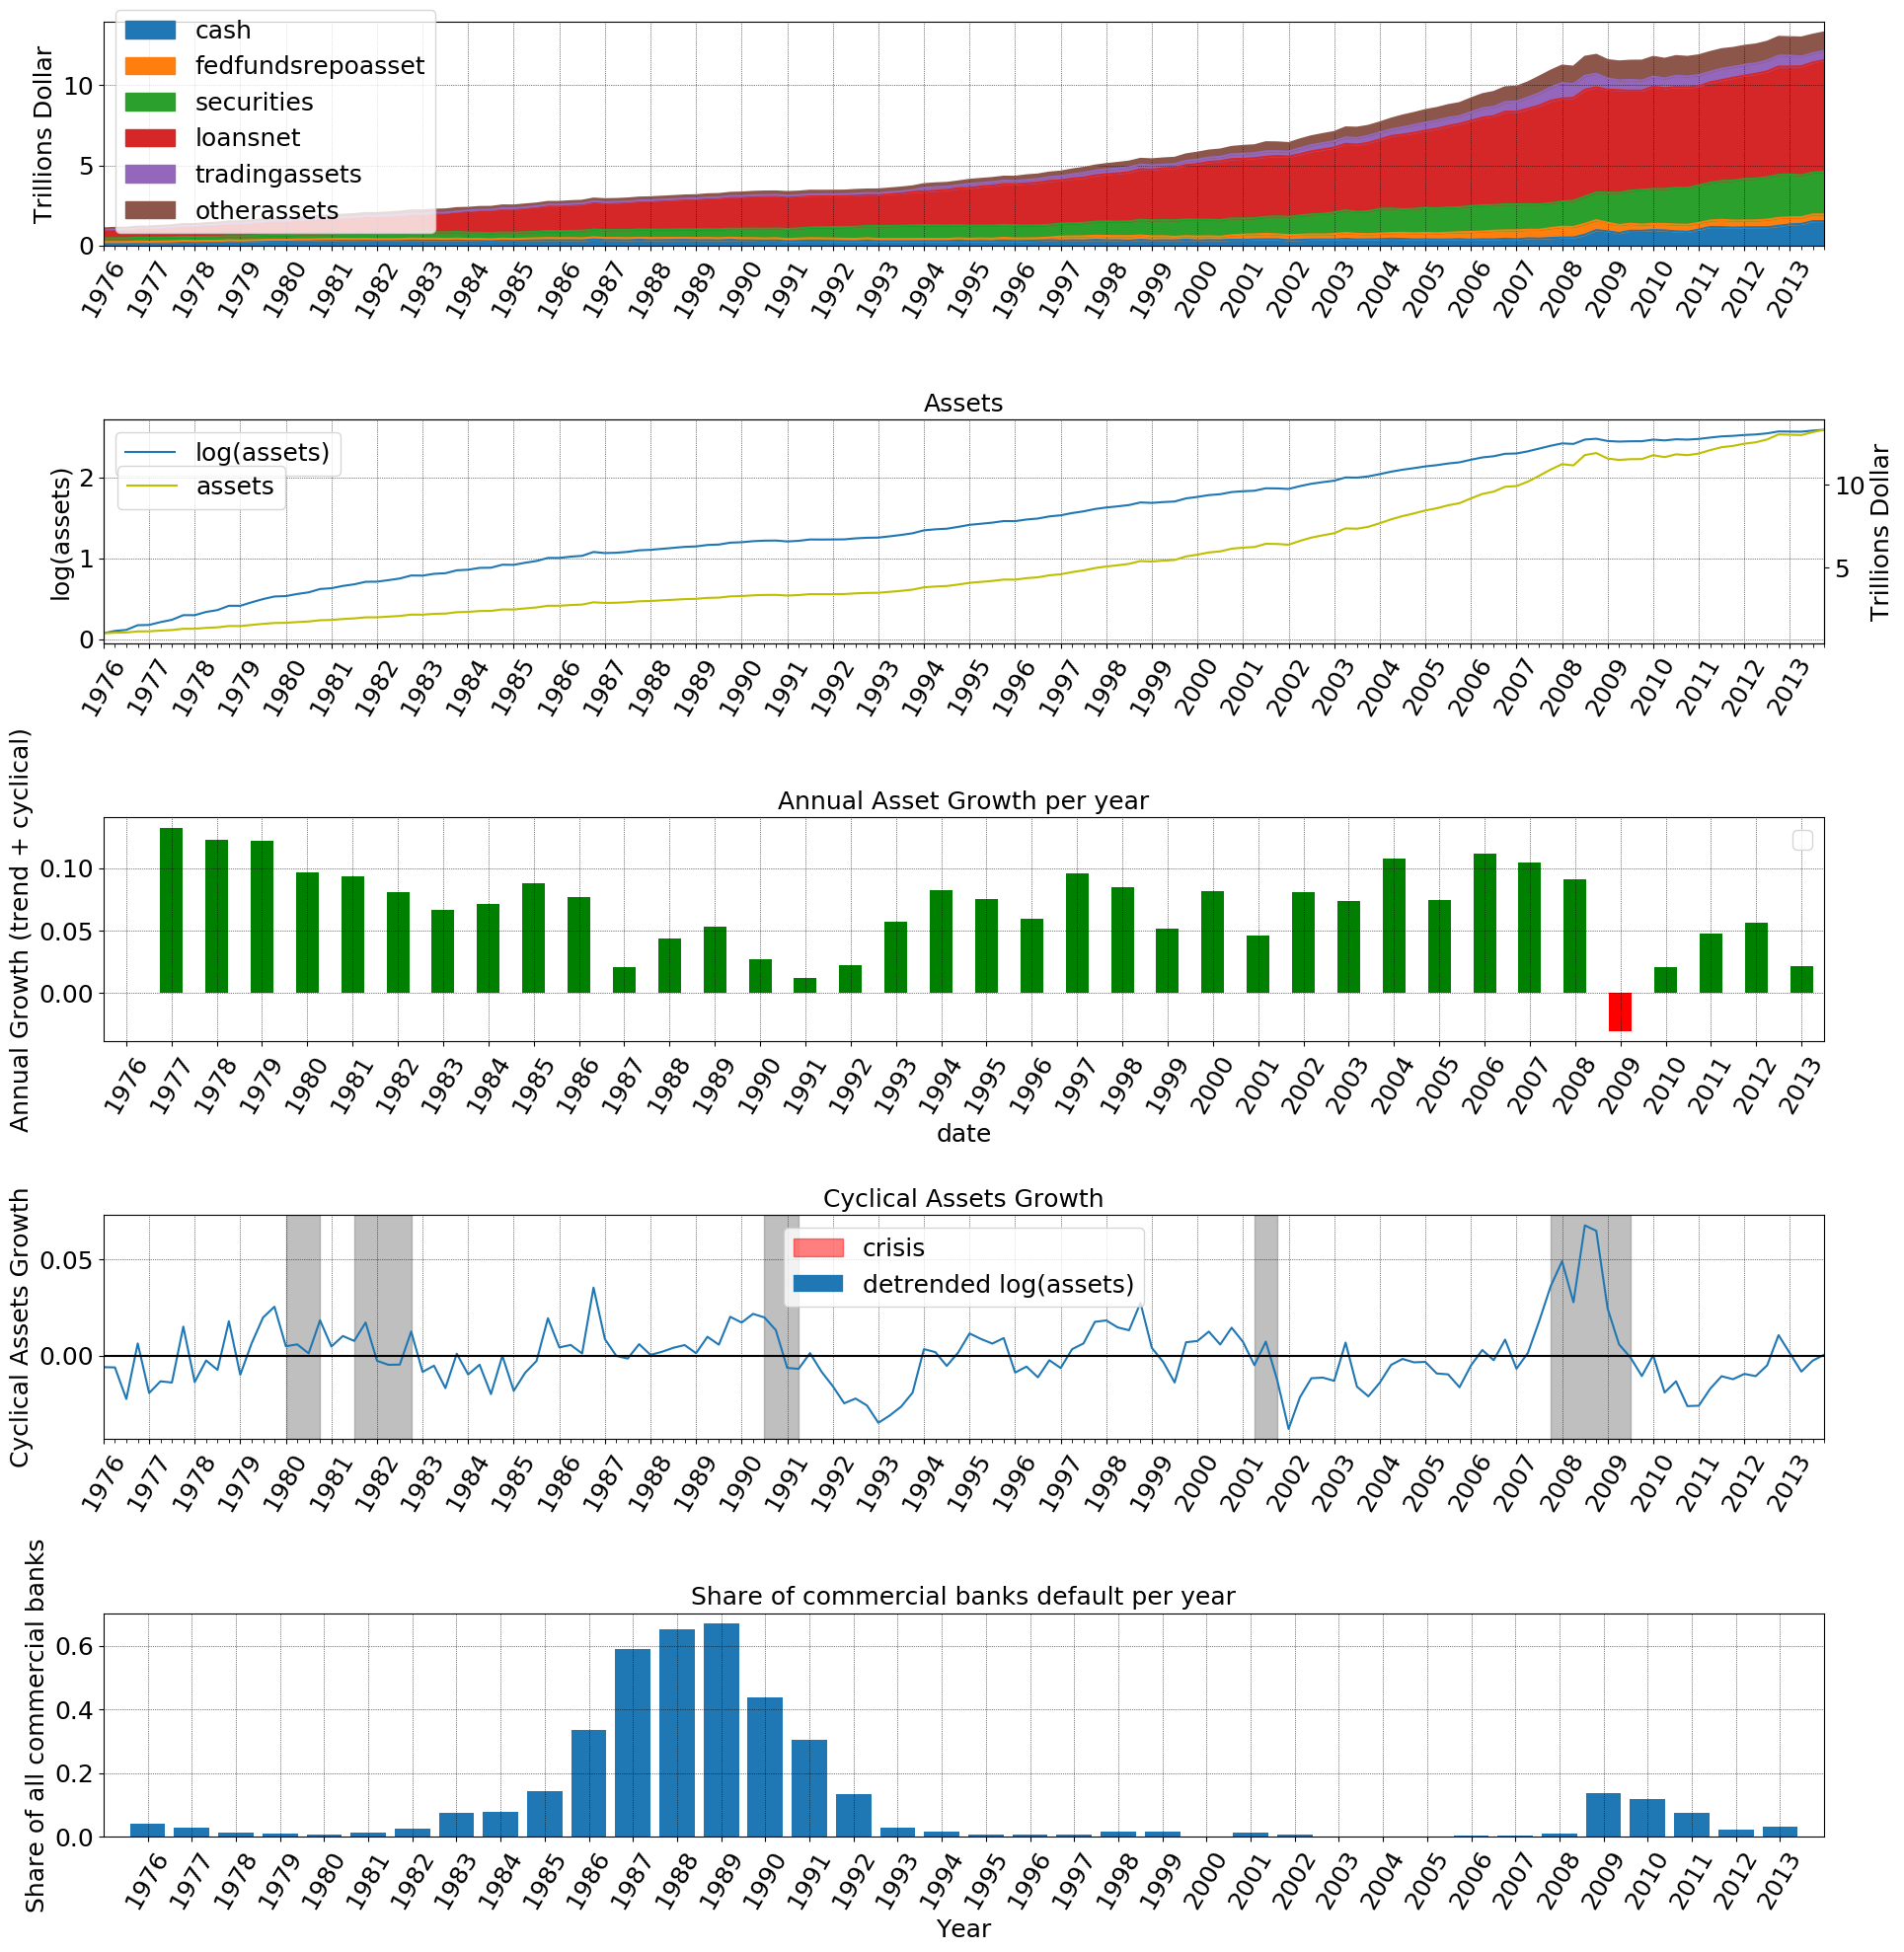

In [16]:
fig, ax = plt.subplots(5,1,figsize=(20,20))
ax = ax.ravel()

#ax_twin = ax[1].twinx()



#graph: absolute assets
ax[0].set_ylabel("Trillions Dollar")
ax[0].set_xticks(range(0,151,4))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))

df_agg_scaled.plot.area(ax=ax[0], y=["cash","fedfundsrepoasset" ,"securities",
                           "loansnet", "tradingassets", "otherassets"])


ax[0].set_xticklabels(years, rotation=60)
ax[0].set_xlim(0, 151)
ax[0].legend()
ax[0].grid()

#ax.yaxis.set_major_formatter(mlt.ticker.StrMethodFormatter("{x:g}")) 

#graph: log(assets)
df_agg_log = np.log(df_agg_scaled)
ax[1].set_xticks(range(0,151,4))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
df_agg_log.assets.plot(ax=ax[1], color="C0")
ax[1].set_xticklabels(years, rotation=60)
ax[1].set_ylabel("log(assets)")
ax[1].legend(["log(assets)"])
ax[1].grid()
ax[1].set_xlim(0, 151)
ax[1].set_title("Assets")



#graph: cyclical of log(assets)
cycle, trend = sm.tsa.filters.hpfilter(df_agg_log.assets, 1600)
df_agg_log["cycle"] = cycle
df_agg_log.cycle.plot(ax=ax[3])

ax[3].set_ylabel("Cyclical Assets Growth")
ax[3].axhline(color="black")
ax[3].set_xticks(range(0,151,4))
ax[3].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[3].set_xticklabels(years, rotation=60)
red_patch = mpatches.Patch(color='red',alpha=0.5)
red_patch1 = mpatches.Patch(color='C0', lw=0.2)
ax[3].legend(handles=[red_patch, red_patch1], labels=["crisis", "detrended log(assets)"])
ax[3].grid()
ax[3].set_xlim(0, 151)
plot_crisis(ax[3])
ax[3].set_title("Cyclical Assets Growth")

#plot growth graph
#ax4.bar(height =df_agg_pct_change.pct_change, x=df_agg_pct_change.index)
df_agg_pct_change["positive"] = df_agg_pct_change["pct_change"] > 0
df_agg_pct_change.plot(y="pct_change", kind="bar", ax=ax[2], color=df_agg_pct_change.positive.map({True: 'g', False: 'r'}))
ax[2].grid()
ax[2].legend("")
ax[2].set_xticks(range(0,38))
ax[2].set_ylabel("Annual Growth (trend + cyclical)")
ax[2].set_xticklabels(years, rotation=60)
ax[2].set_title("Annual Asset Growth per year")


#plot defaults graph

ax[4].set_title("Share of commercial banks default per year")
ax[4].set_ylabel("Share of all commercial banks")
ax[4].set_xlabel("Year")
x = np.arange(len(d_default_averageYear))
ax[4].bar(x, d_default_averageYear.Percentage)
ax[4].set_xticks(range(0,38))
ax[4].set_xticklabels(years, rotation=60)
ax[4].set_xlim(-1, 38)
ax[4].grid()



#plot twin axis for second graph
ax_twin = ax[1].twinx()
ax_twin.plot(df_agg_scaled.assets, "y")
ax_twin.legend(["assets"], loc=[0.008, 0.6])
ax_twin.set_ylabel("Trillions Dollar")






plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_AssetDistribution_7613.png')

Cycle of both assets and liabilities positions

In [17]:

# choosing asset positions
df_agg_log_assets = df_agg_log.iloc[:, 5:11]

#choosing liabilities positions
df_agg_liab_log_positions =  df_agg_liab_log.iloc[:,5:13]

#concat
#df_agg_allpositions = pd.concat([df_agg_log_assets, df_agg_liab_log_positions], axis=1)
#index_year = df_agg_liab_log.iloc[:,:3] 
#df_agg_allpositions = pd.concat([index_year, df_agg_allpositions], axis=1)

#replace inf with nan
df_agg_liab_log_positions.replace([np.inf, -np.inf], np.nan, inplace=True)
df_agg_log_assets.replace([np.inf, -np.inf], np.nan, inplace=True)


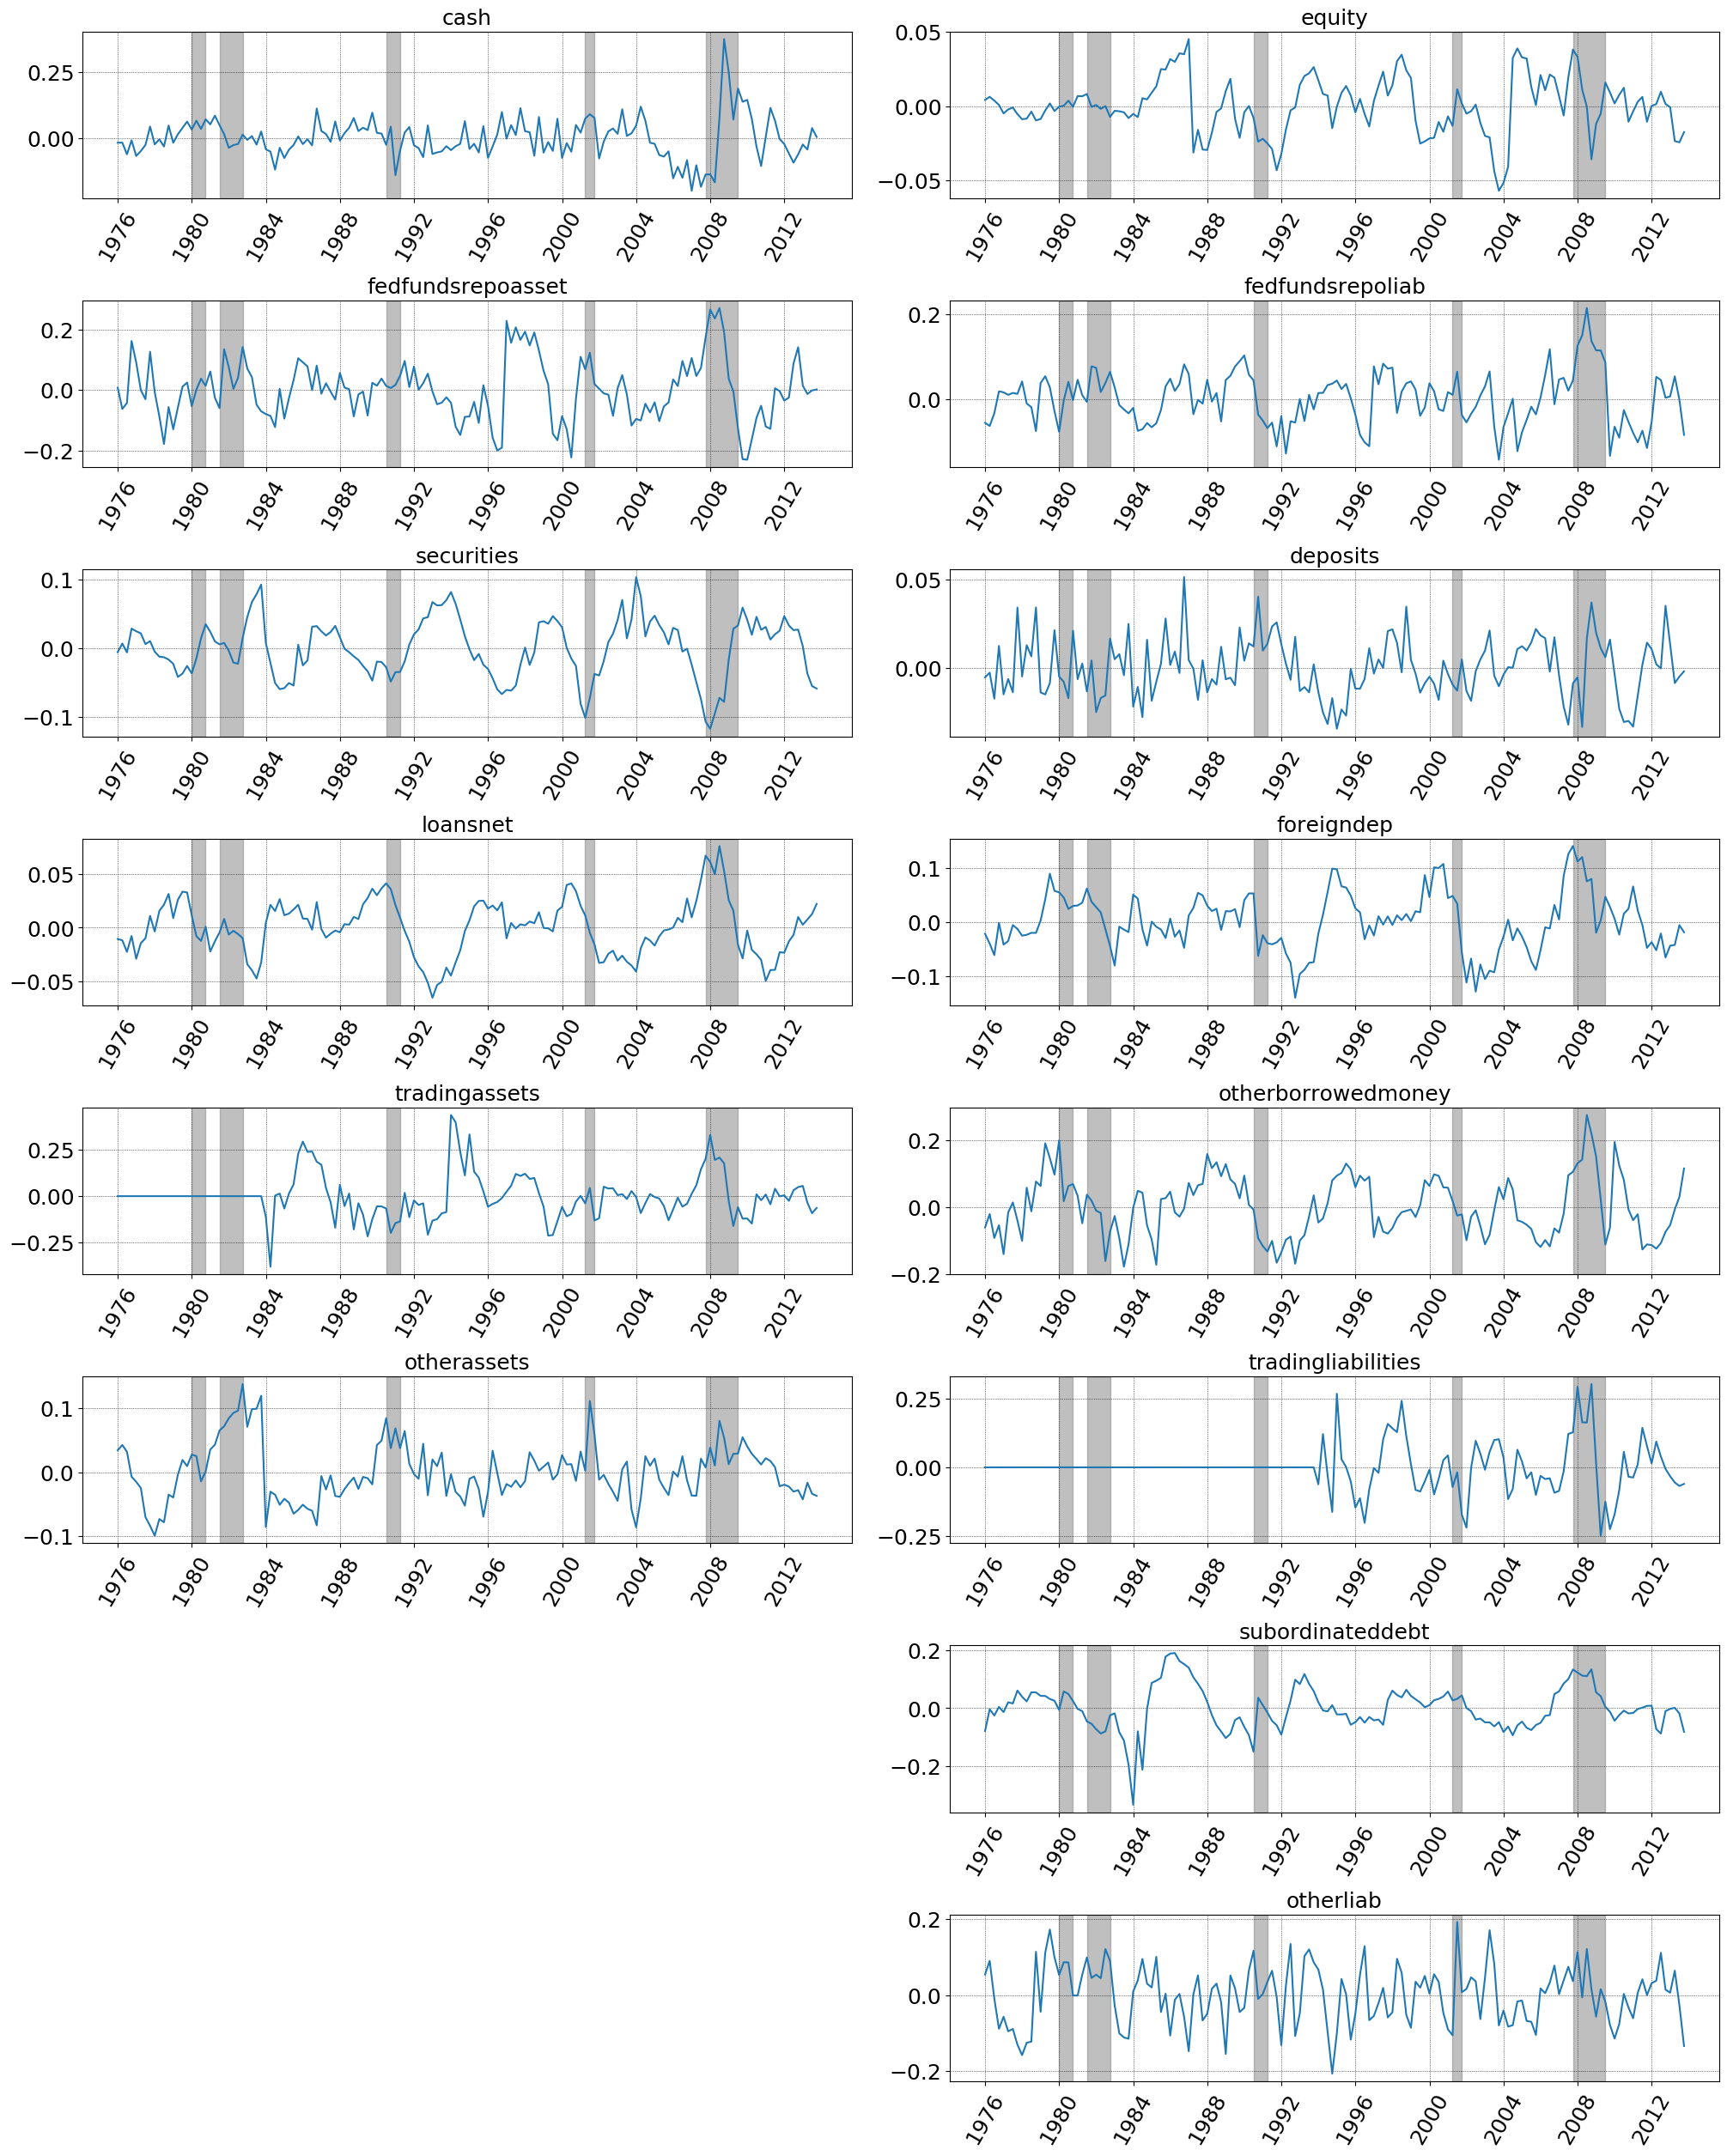

In [18]:
fig, ax = plt.subplots(8,2, figsize=(20,25), constrained_layout=True)
ax = ax.ravel()


#excluding other liabilities

#getting positon names
asset_positions_array = df_agg_log_assets.columns.values
liab_positions_array = df_agg_liab_log_positions.columns.values

#overall counter
i = 0

#asset positions counter
x = 0

#liabilities counter
y = 0

#dataframe to save all cycles
df_cycle_assets = pd.DataFrame()
df_cycle_liab = pd.DataFrame()

'''
This whole loop computes the the cycles for both asset and liabilities positions. It differentiates them,
so asset positions are plotted on the left column and liabilities positions on the right column.
Also, there are two cases, trading assets and trading liabilities which are treated special because of nan values
which mess up the cycle computation. 
'''

for i in range(16):
    #when we are in the left column and there is still an asset position
    if ((i % 2) == 0 and (x) < len(asset_positions_array)):
        #if position is tradingassets then fix wrong values
        if (asset_positions_array[x].startswith("trading")):
            #remove zeros for cycle estimation
            temp_series = df_agg_log_assets[asset_positions_array[x]]
            temp_series.dropna(inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(temp_series, 1600)
            #insert zeros back into cycle
            count_missing_values = 152 - cycle.size
            zeros = pd.Series(np.zeros(count_missing_values))
            cycle = pd.concat([zeros, cycle])
            ax[i].set_title(asset_positions_array[x])
            #save cycle
            df_cycle_assets[asset_positions_array[x]]=cycle
            #ax[i].set_ylabel("log(" + asset_positions_array[x] + ")")
        #not tradingassets then calculate cycle here
        else:
            #replace missing values with zero
            df_agg_log_assets[asset_positions_array[x]].fillna(0, inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(df_agg_log_assets[asset_positions_array[x]], 1600)
            ax[i].set_title(asset_positions_array[x])
            #save cycle
            df_cycle_assets[asset_positions_array[x]]=cycle
            #ax[i].set_ylabel("log(" + asset_positions_array[x] + ")")
        #plot cycle    
        ax[i].set_xticks(range(0,152,16))
        ax[i].set_xticklabels(years16, rotation=60)
        ax[i].plot(cycle)
        ax[i].grid()
        #plot crisis
        plot_crisis(ax[i])
        #increase asset counter by one
        x = x+1
    #when we are in the right column 
    elif ((i % 2) != 0):
        #if position is tradingliab then fix wrong values
        if (liab_positions_array[y].startswith("trading")):
            #remove zeros for cycle estimation
            temp_series = df_agg_liab_log_positions[liab_positions_array[y]]
            temp_series.dropna(inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(temp_series, 1600)
            #insert zeros back into cycle
            count_missing_values = 152 - cycle.size
            zeros = pd.Series(np.zeros(count_missing_values))
            cycle = pd.concat([zeros, cycle])
            ax[i].set_title(liab_positions_array[y])
            #save cycle
            df_cycle_liab[liab_positions_array[y]]=cycle
            #ax[i].set_ylabel("log(" + liab_positions_array[y] + ")")
        #not tradingassets then calculate cycle here
        else:
            #replace missing values with zero
            df_agg_liab_log_positions[liab_positions_array[y]].fillna(0, inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(df_agg_liab_log_positions[liab_positions_array[y]], 1600)
            ax[i].set_title(liab_positions_array[y])
            #save cycle
            df_cycle_liab[liab_positions_array[y]]=cycle
            #ax[i].set_ylabel("log(" + liab_positions_array[y] + ")")
        #plot cycle
        ax[i].set_xticks(range(0,152,16))
        ax[i].set_xticklabels(years16, rotation=60)
        ax[i].plot(cycle)
        y = y+1
        ax[i].grid()
        plot_crisis(ax[i])
    


fig.delaxes(ax[12])
fig.delaxes(ax[14])


plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_PositionsCyclical_7613.png')

Compute correlation tables

Functions

In [19]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    pvalues = pvalues.astype("float")
    return pvalues

In [20]:
def calculate_pvalues_2(df1, df2):
    df1 = df1.dropna()._get_numeric_data()
    df2 = df2.dropna()._get_numeric_data()
    df1cols = pd.DataFrame(columns=df1.columns)
    df2cols = pd.DataFrame(columns=df2.columns)
    pvalues = df2cols.transpose().join(df1cols, how='outer')
    for r in df1.columns:
        for c in df2.columns:
            pvalues[r][c] = round(pearsonr(df1[r], df2[c])[1], 4)
    pvalues = pvalues.astype("float")
    return pvalues

In [21]:
#apply color to significant values
def color_sig(val):
    
    color = 'royalblue' if val[-3:] == "***" else 'default'
    
    return 'background-color: %s' % color

Color scale for colormap

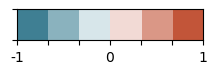

In [22]:
cmap=sns.diverging_palette(220, 20, sep=20)

sns.palplot(cmap, size=0.4)

ax = plt.gca()

#ax.xaxis.set_major_locator(ticker.FixedLocator([-0.5,0.5,1.5,2.5,3.5,4.5,5.5]))
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0))
ax.xaxis.set_major_formatter(ticker.FixedFormatter([-1,"","",0,"","",1 ]))
ax.tick_params(axis='both', which='major', labelsize=10)
#ax.set_xticks([-0.5,0.5,1.5,2.5,3.5,4.5,5.5])
#ax.set_xticklabels()

Compute Correlations

In [23]:
df_agg_log

,year,quarter,rssdid,bhcid,assets,cash,fedfundsrepoasset,securities,loansnet,tradingassets,otherassets,otherliab,cycle
0,-13.134436,-20.723266,1.998908,1.400516,0.071050,-1.693375,-3.323719,-1.472848,-0.571553,-inf,-2.816761,-3.436093,-0.006021
1,-13.134436,-20.030119,2.001522,1.409213,0.099967,-1.661493,-3.360419,-1.445313,-0.541724,-inf,-2.762370,-3.336463,-0.006164
2,-13.134436,-19.624654,2.000468,1.417602,0.112649,-1.674249,-3.307651,-1.443399,-0.521484,-inf,-2.726843,-3.371570,-0.022539
3,-13.134436,-19.336971,2.002789,1.427576,0.170502,-1.589668,-3.070429,-1.393968,-0.475591,-inf,-2.719628,-3.387157,0.006269
4,-13.133930,-20.723266,2.001237,1.431152,0.173825,-1.617892,-3.107793,-1.382902,-0.466003,-inf,-2.681264,-3.291473,-0.019421
5,-13.133930,-20.030119,2.004028,1.441965,0.208847,-1.567835,-3.166294,-1.371191,-0.420472,-inf,-2.644236,-3.265378,-0.013360
6,-13.133930,-19.624654,2.001277,1.448962,0.237079,-1.513949,-3.162954,-1.371940,-0.385014,-inf,-2.643021,-3.194590,-0.014009
7,-13.133930,-19.336971,2.000974,1.454858,0.294836,-1.413561,-2.973641,-1.352633,-0.333538,-inf,-2.609497,-3.171172,0.014987
8,-13.133424,-20.723266,1.997872,1.461046,0.294694,-1.451264,-3.073082,-1.352812,-0.317876,-inf,-2.577579,-3.133720,-0.013752
9,-13.133424,-20.030119,1.998600,1.472966,0.334280,-1.402812,-3.119219,-1.344918,-0.268516,-inf,-2.503920,-3.036710,-0.002557


In [24]:
#Correlations
corr_assets = df_cycle_assets.corr()

corr_liab = df_cycle_liab.corr()

corr_comb = df_cycle_liab.apply(lambda x: df_cycle_assets.corrwith(x))

#Autocorrelations

df_cycle_auto_corr = pd.DataFrame()

#for total assets cycle
temp_array = []
for i in range(0,9):
    temp_array.append(df_agg_log.cycle.autocorr(lag=i))
    
df_cycle_auto_corr["assets"] = temp_array

#for rest asset positions
for column in df_cycle_assets:
    temp_array = []
    for i in range(0,9):
        temp_array.append(df_cycle_assets[column].autocorr(lag=i))
    df_cycle_auto_corr[column] = temp_array

#for rest liab positions
for column in df_cycle_liab:
    temp_array = []
    for i in range(0,9):
        temp_array.append(df_cycle_liab[column].autocorr(lag=i))
    df_cycle_auto_corr[column] = temp_array



df_cycle_auto_corr.index.rename("lag", inplace=True)

df_cycle_auto_corr.iloc[:,0:7]

df_cycle_auto_corr.iloc[:,7:]

,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
lag,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.723293,0.628063,0.328080,0.798504,0.731746,0.529164,0.805696,0.368007
2,0.449616,0.404419,0.292106,0.661453,0.541543,0.243973,0.689890,0.012917
3,0.179874,0.211710,0.055729,0.463610,0.361965,0.147006,0.509253,0.078217
4,0.009426,0.183654,0.348144,0.329830,0.283648,-0.132563,0.336406,0.145914
5,-0.103217,0.005744,-0.196956,0.117763,0.173004,-0.291591,0.190992,-0.091779
6,-0.109206,-0.058821,-0.179869,0.001884,0.064673,-0.387505,0.081116,-0.295527
7,-0.155159,-0.182500,-0.321517,-0.124807,-0.095045,-0.427252,-0.068200,-0.089373
8,-0.143907,-0.143367,0.106174,-0.155675,-0.215672,-0.382195,-0.173296,0.008344


Correlation table for assets

In [25]:
from matplotlib import colors

corr_assets = corr_assets.round(2)
pval = calculate_pvalues(df_cycle_assets)
A = pval.copy()

#cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

'''
Alter matrix s background color based on the value of matrix A
'''

def b_g(s, cmap='coolwarm', low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


#create three masks
r1 = corr_assets.applymap(lambda x: '{}*'.format(x))
r2 = corr_assets.applymap(lambda x: '{}**'.format(x))
r3 = corr_assets.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
corr_assets_sig = corr_assets.copy()
corr_assets_sig = corr_assets_sig.mask(pval<=0.1,r1)
corr_assets_sig = corr_assets_sig.mask(pval<=0.05,r2)
corr_assets_sig = corr_assets_sig.mask(pval<=0.01,r3)

#corr_assets_sig = corr_assets.style.background_gradient(cmap='coolwarm', axis=None)\
#    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
#    .set_precision(2)\
#    .format(lambda x: '{}***'.format(x))\


corr_assets_sig = corr_assets_sig.style.apply(b_g,cmap='coolwarm')



corr_assets_sig


,cash,fedfundsrepoasset,securities,loansnet,tradingassets,otherassets
cash,1.0***,-0.070000,0.060000,-0.010000,-0.080000,0.100000
fedfundsrepoasset,-0.070000,1.0***,-0.34***,0.23***,0.34***,0.15*
securities,0.060000,-0.34***,1.0***,-0.73***,-0.120000,-0.010000
loansnet,-0.010000,0.23***,-0.73***,1.0***,0.110000,-0.060000
tradingassets,-0.080000,0.34***,-0.120000,0.110000,1.0***,-0.120000
otherassets,0.100000,0.15*,-0.010000,-0.060000,-0.120000,1.0***


In [26]:
pval = calculate_pvalues(df_cycle_assets)

corr_assets = corr_assets.round(2)

#create three masks
r1 = corr_assets.applymap(lambda x: '{}*'.format(x))
r2 = corr_assets.applymap(lambda x: '{}**'.format(x))
r3 = corr_assets.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
corr_assets_sig = corr_assets.copy()
corr_assets_sig = corr_assets_sig.mask(pval<=0.1,r1)
corr_assets_sig = corr_assets_sig.mask(pval<=0.05,r2)
corr_assets_sig = corr_assets_sig.mask(pval<=0.01,r3)

corr_assets_sig

corr_assets_sig = corr_assets_sig.astype("str")

corr_assets_sig.style.applymap(color_sig)

,cash,fedfundsrepoasset,securities,loansnet,tradingassets,otherassets
cash,1.0***,-0.07,0.06,-0.01,-0.08,0.1
fedfundsrepoasset,-0.07,1.0***,-0.34***,0.23***,0.34***,0.15*
securities,0.06,-0.34***,1.0***,-0.73***,-0.12,-0.01
loansnet,-0.01,0.23***,-0.73***,1.0***,0.11,-0.06
tradingassets,-0.08,0.34***,-0.12,0.11,1.0***,-0.12
otherassets,0.1,0.15*,-0.01,-0.06,-0.12,1.0***


Correlation table for liabilities

In [27]:
corr_liab.style.background_gradient(cmap='coolwarm', axis=None)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
equity,1.00,0.21,-0.02,0.04,-0.06,0.12,0.27,0.08
fedfundsrepoliab,0.21,1.00,0.04,0.32,0.23,0.28,0.25,0.07
deposits,-0.02,0.04,1.00,-0.34,-0.23,0.04,0.11,-0.11
foreigndep,0.04,0.32,-0.34,1.00,0.59,0.16,0.13,0.06
otherborrowedmoney,-0.06,0.23,-0.23,0.59,1.00,0.08,0.15,0.01
tradingliabilities,0.12,0.28,0.04,0.16,0.08,1.00,0.18,0.15
subordinateddebt,0.27,0.25,0.11,0.13,0.15,0.18,1.00,0.04
otherliab,0.08,0.07,-0.11,0.06,0.01,0.15,0.04,1.00


In [28]:
pval = calculate_pvalues(df_cycle_liab)

corr_liab = corr_liab.round(2)

#create three masks
r1 = corr_liab.applymap(lambda x: '{}*'.format(x))
r2 = corr_liab.applymap(lambda x: '{}**'.format(x))
r3 = corr_liab.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
corr_liab_sig = corr_liab.copy()
corr_liab_sig = corr_liab_sig.mask(pval<=0.1,r1)
corr_liab_sig = corr_liab_sig.mask(pval<=0.05,r2)
corr_liab_sig = corr_liab_sig.mask(pval<=0.01,r3)



corr_liab_sig = corr_liab_sig.astype("str")

corr_liab_sig.style.applymap(color_sig)

,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
equity,1.0***,0.21***,-0.02,0.04,-0.06,0.12,0.27***,0.08
fedfundsrepoliab,0.21***,1.0***,0.04,0.32***,0.23***,0.28***,0.25***,0.07
deposits,-0.02,0.04,1.0***,-0.34***,-0.23***,0.04,0.11,-0.11
foreigndep,0.04,0.32***,-0.34***,1.0***,0.59***,0.16**,0.13,0.06
otherborrowedmoney,-0.06,0.23***,-0.23***,0.59***,1.0***,0.08,0.15*,0.01
tradingliabilities,0.12,0.28***,0.04,0.16**,0.08,1.0***,0.18**,0.15*
subordinateddebt,0.27***,0.25***,0.11,0.13,0.15*,0.18**,1.0***,0.04
otherliab,0.08,0.07,-0.11,0.06,0.01,0.15*,0.04,1.0***


Correlation table for correlation assets with liabilities

In [29]:
corr_comb.style.background_gradient(cmap='coolwarm', axis=None)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\


,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
cash,-0.25,0.06,0.38,0.04,0.28,-0.03,0.03,-0.14
fedfundsrepoasset,0.21,0.57,0.32,0.03,-0.12,0.48,0.30,0.14
securities,-0.06,-0.23,0.08,-0.38,-0.33,-0.16,-0.18,-0.18
loansnet,0.06,0.41,0.17,0.59,0.54,0.15,0.21,0.14
tradingassets,0.37,0.36,-0.09,0.23,0.14,0.49,0.35,0.01
otherassets,0.02,0.10,-0.01,0.12,-0.07,0.04,-0.18,0.35


In [30]:
pval = calculate_pvalues_2(df_cycle_liab, df_cycle_assets)

corr_comb = corr_comb.round(2)

#create three masks
r1 = corr_comb.applymap(lambda x: '{}*'.format(x))
r2 = corr_comb.applymap(lambda x: '{}**'.format(x))
r3 = corr_comb.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
corr_comb_sig = corr_comb.copy()
corr_comb_sig = corr_comb_sig.mask(pval<=0.1,r1)
corr_comb_sig = corr_comb_sig.mask(pval<=0.05,r2)
corr_comb_sig = corr_comb_sig.mask(pval<=0.01,r3)


corr_comb_sig = corr_comb_sig.astype("str")

corr_comb_sig.style.applymap(color_sig)

,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
cash,-0.25***,0.06,0.38***,0.04,0.28***,-0.03,0.03,-0.14*
fedfundsrepoasset,0.21***,0.57***,0.32***,0.03,-0.12,0.48***,0.3***,0.14*
securities,-0.06,-0.23***,0.08,-0.38***,-0.33***,-0.16**,-0.18**,-0.18**
loansnet,0.06,0.41***,0.17**,0.59***,0.54***,0.15*,0.21**,0.14*
tradingassets,0.37***,0.36***,-0.09,0.23***,0.14*,0.49***,0.35***,0.01
otherassets,0.02,0.1,-0.01,0.12,-0.07,0.04,-0.18**,0.35***


Scatterplots for selected correlations

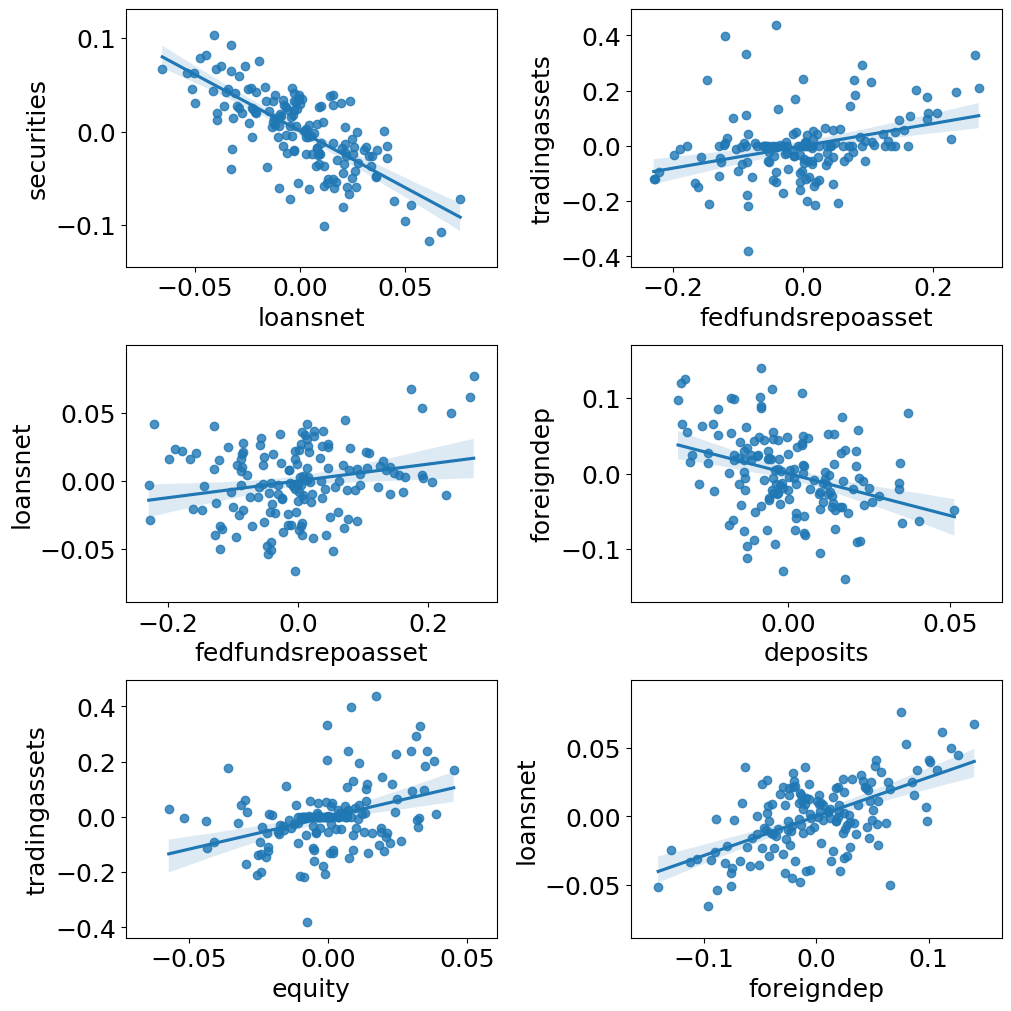

In [31]:
fig, ax = plt.subplots(3,2,figsize=(10,10),  constrained_layout=True)
ax = ax.ravel()


sns.regplot(x="loansnet", y="securities",ax=ax[0], data=df_cycle_assets, robust=True)
sns.regplot(x="fedfundsrepoasset", y="tradingassets",ax=ax[1],  data=df_cycle_assets)
sns.regplot(x="fedfundsrepoasset", y="loansnet",ax=ax[2],  data=df_cycle_assets)
sns.regplot(x="deposits", y="foreigndep",ax=ax[3],  data=df_cycle_liab)
sns.regplot(x=df_cycle_liab.equity, y=df_cycle_assets.tradingassets,ax=ax[4])
sns.regplot(x=df_cycle_liab.foreigndep, y=df_cycle_assets.loansnet,ax=ax[5])


plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_scatterplots_7613.png')

Share of balance sheet positions

Compute shares

In [32]:
df_agg

,year,quarter,date,rssdid,bhcid,assets,cash,fedfundsrepoasset,securities,loansnet,tradingassets,otherassets,otherliab
0,1976.0,1.0,1976-03-31,7.380992e+09,4.057292e+09,1.073635e+09,1.838978e+08,36018634.0,2.292715e+08,5.646476e+08,0.0,5.979932e+07,32190192.0
1,1976.0,2.0,1976-06-30,7.400314e+09,4.092732e+09,1.105135e+09,1.898554e+08,34720718.0,2.356722e+08,5.817447e+08,0.0,6.314197e+07,35562537.0
2,1976.0,3.0,1976-09-30,7.392513e+09,4.127212e+09,1.119239e+09,1.874489e+08,36602041.0,2.361238e+08,5.936392e+08,0.0,6.542551e+07,34335681.0
3,1976.0,4.0,1976-12-31,7.409692e+09,4.168581e+09,1.185900e+09,2.039932e+08,46401229.0,2.480889e+08,6.215177e+08,0.0,6.589929e+07,33804637.0
4,1977.0,1.0,1977-03-31,7.398205e+09,4.183515e+09,1.189848e+09,1.983163e+08,44699487.0,2.508496e+08,6.275057e+08,0.0,6.847658e+07,37199022.0
5,1977.0,2.0,1977-06-30,7.418879e+09,4.228996e+09,1.232257e+09,2.084960e+08,42159541.0,2.538045e+08,6.567370e+08,0.0,7.105964e+07,38182517.0
6,1977.0,3.0,1977-09-30,7.398497e+09,4.258692e+09,1.267541e+09,2.200393e+08,42300589.0,2.536145e+08,6.804410e+08,0.0,7.114599e+07,40983329.0
7,1977.0,4.0,1977-12-31,7.396260e+09,4.283876e+09,1.342907e+09,2.432755e+08,51116863.0,2.585585e+08,7.163844e+08,0.0,7.357152e+07,41954411.0
8,1978.0,1.0,1978-03-31,7.373350e+09,4.310468e+09,1.342715e+09,2.342740e+08,46278307.0,2.585122e+08,7.276929e+08,0.0,7.595768e+07,43555471.0
9,1978.0,2.0,1978-06-30,7.378716e+09,4.362155e+09,1.396934e+09,2.459044e+08,44191687.0,2.605611e+08,7.645133e+08,0.0,8.176384e+07,47992509.0


In [33]:
#Shares assets
df_agg_share_assets = pd.DataFrame()

for (columnName, columnData) in df_agg.select_dtypes(include=['float64']).iteritems():
    newcolumn = "share" + columnName
    df_agg_share_assets[newcolumn] = df_agg[columnName]/df_agg.assets
    
    
df_agg_share_assets.drop(['shareyear', 'sharequarter', "sharerssdid" , "shareassets", "sharebhcid", "shareotherliab"], axis=1, inplace=True)

#share assets without loans
df_agg_share_assets_noLoans = df_agg_share_assets.drop(["shareloansnet"], axis=1)

#Shares liabs
df_agg_share_liab = pd.DataFrame()

for (columnName, columnData) in df_agg_liab.select_dtypes(include=['float64']).iteritems():
    newcolumn = "share" + columnName
    df_agg_share_liab[newcolumn] = df_agg_liab[columnName]/df_agg.assets
    
    
df_agg_share_liab.drop(['shareyear', 'sharequarter', "sharerssdid" , "shareassets"], axis=1, inplace=True)


#Share liabs without deposits
df_agg_share_liab_noDeposit = df_agg_share_liab.drop(["sharedeposits"], axis=1)

Plot shares

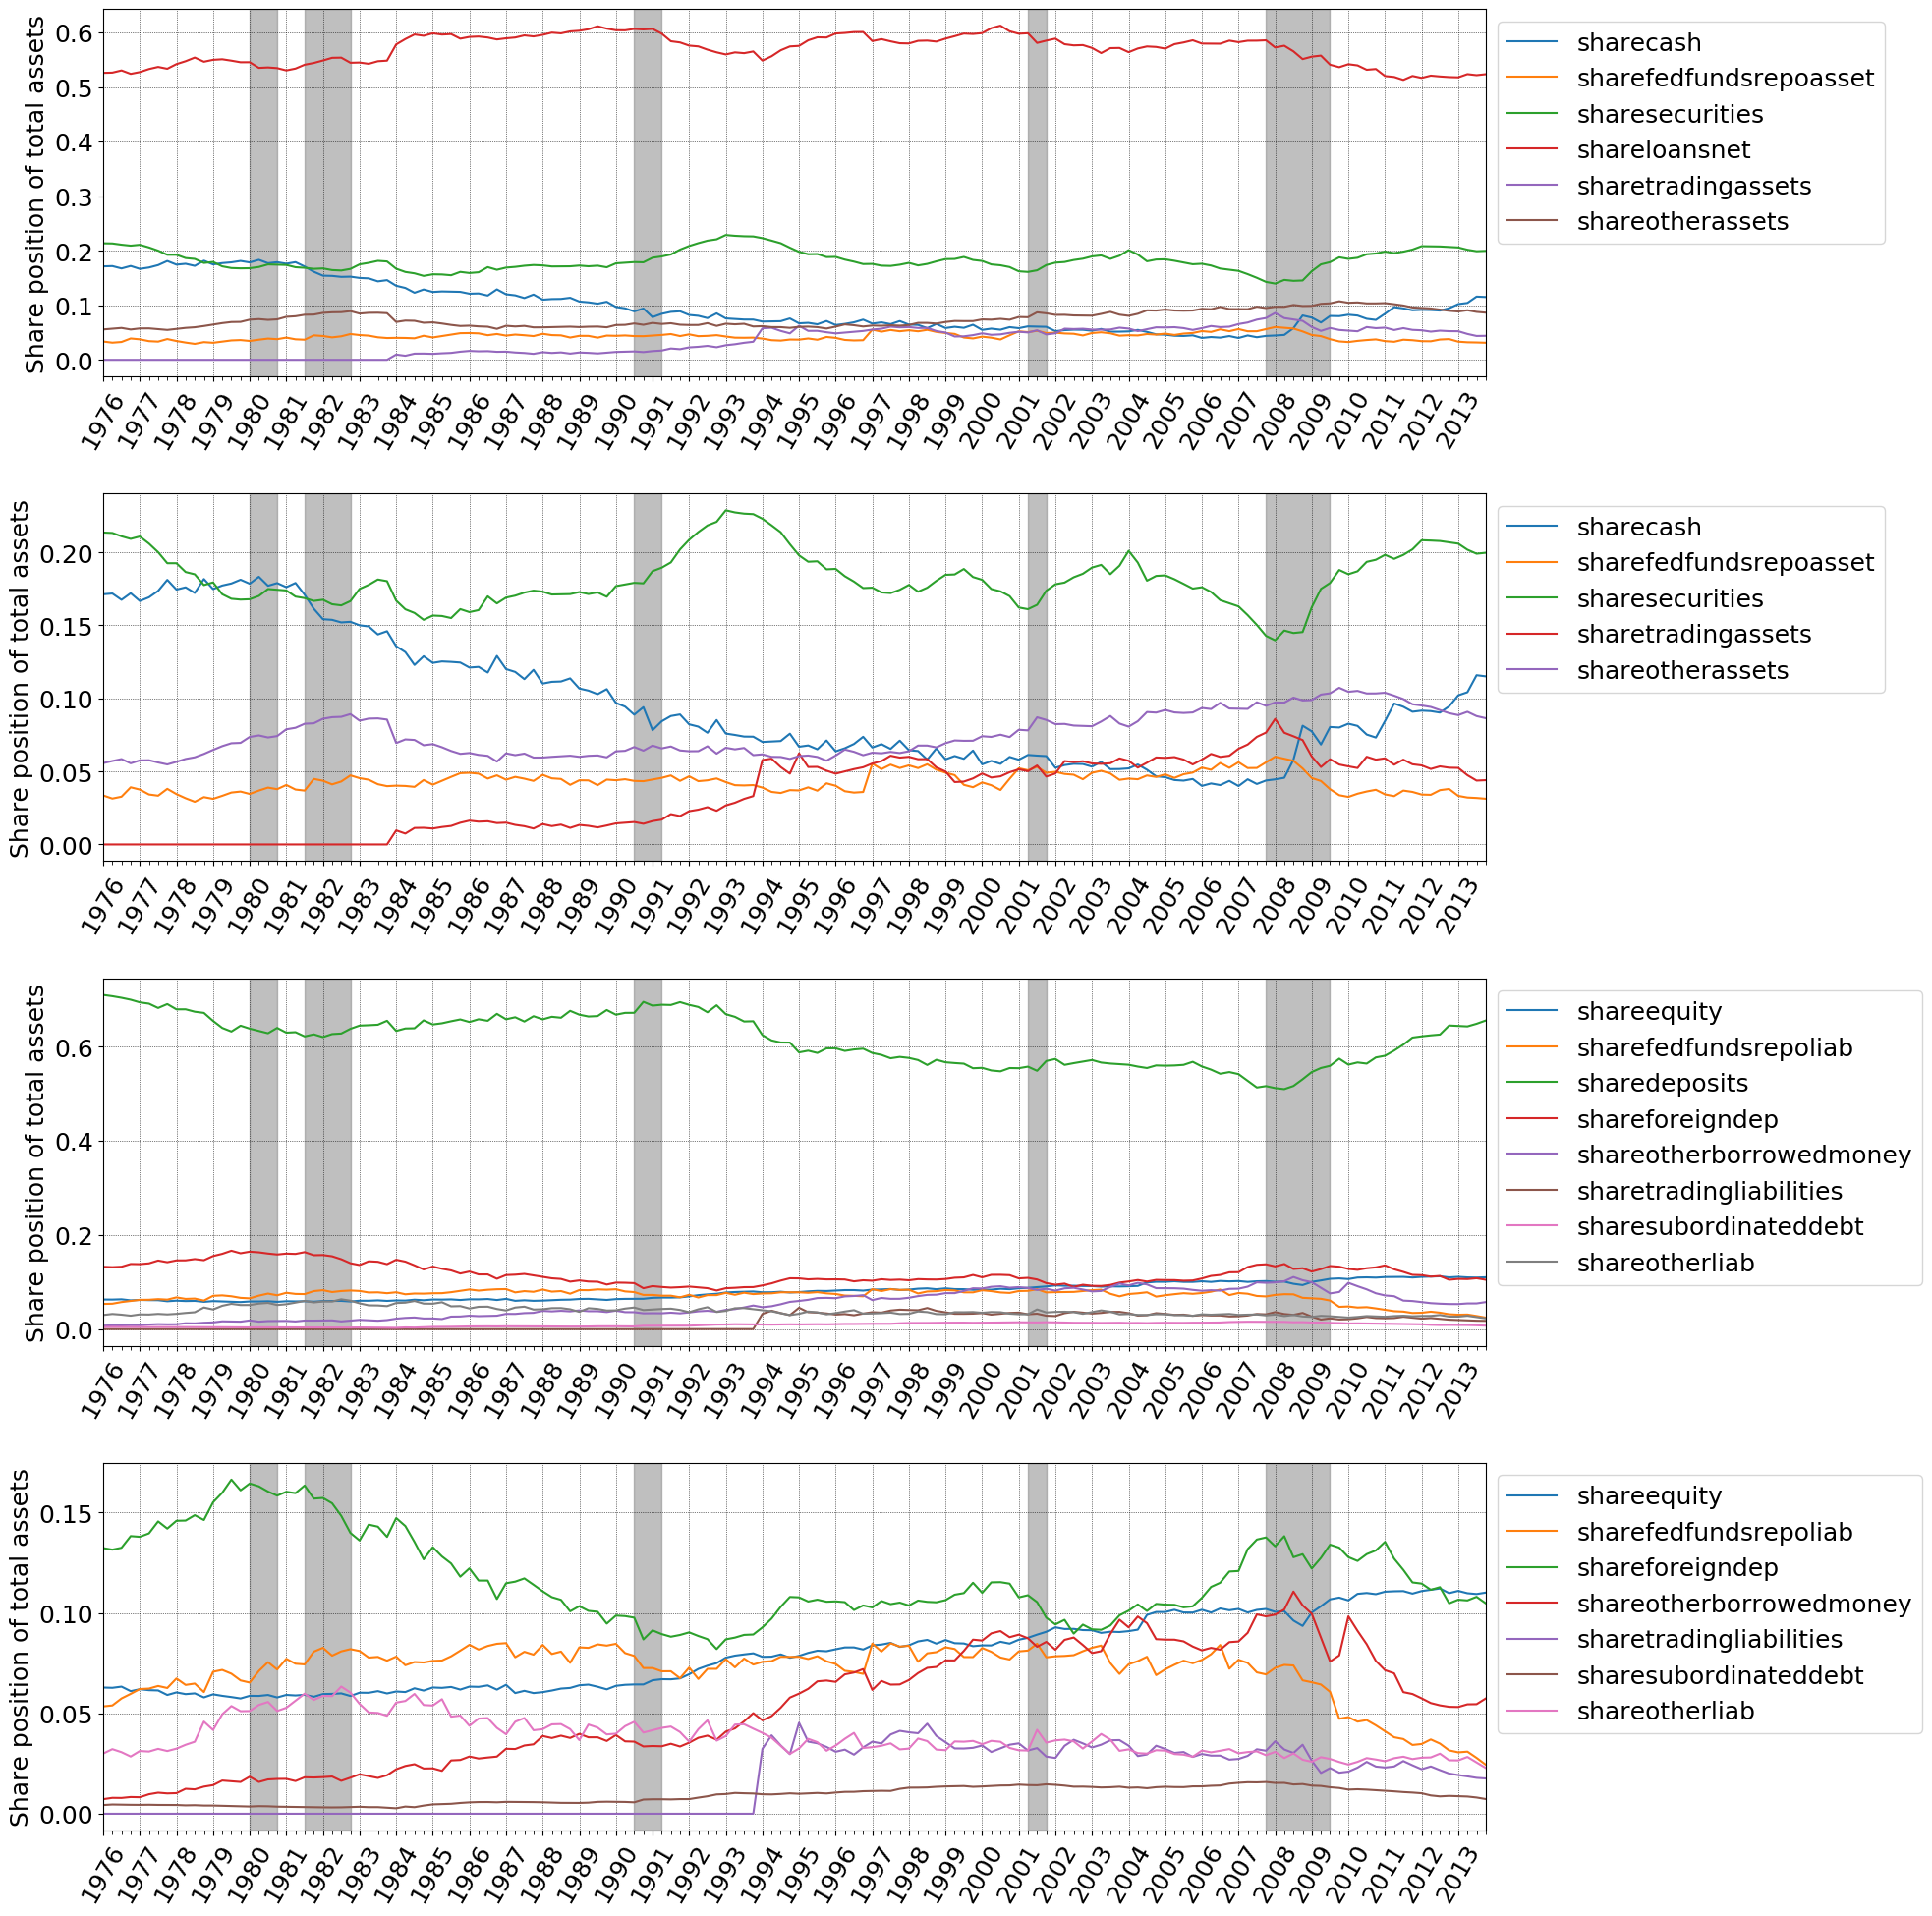

In [34]:
fig, ax = plt.subplots(4,1,figsize=(20,20))
ax= ax.ravel()

#plot share assets subplot
ax[0].plot(df_agg_share_assets)
ax[0].set_xticklabels(years, rotation=60)
ax[0].legend(df_agg_share_assets.columns, bbox_to_anchor=(1, 1))
ax[0].set_xticks(range(0,151,4))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[0].grid(True)
ax[0].set_xlim(0,151)
ax[0].set_ylabel("Share position of total assets")
plot_crisis(ax[0])

#plot without loans
ax[1].plot(df_agg_share_assets_noLoans)
ax[1].set_xticklabels(years, rotation=60)
ax[1].legend(df_agg_share_assets_noLoans.columns, bbox_to_anchor=(1, 1))
ax[1].set_xticks(range(0,151,4))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].grid(True)
ax[1].set_xlim(0,151)
ax[1].set_ylabel("Share position of total assets")
plot_crisis(ax[1])

#plot share liab subplot
ax[2].plot(df_agg_share_liab)
ax[2].set_xticklabels(years, rotation=60)
ax[2].legend(df_agg_share_liab.columns, bbox_to_anchor=(1, 1))
ax[2].set_xticks(range(0,151,4))
ax[2].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[2].grid(True)
ax[2].set_xlim(0,151)
ax[2].set_ylabel("Share position of total assets")
plot_crisis(ax[2])


#plot without deposits
ax[3].plot(df_agg_share_liab_noDeposit)
ax[3].set_xticklabels(years, rotation=60)
ax[3].legend(df_agg_share_liab_noDeposit.columns, bbox_to_anchor=(1, 1))
ax[3].set_xticks(range(0,151,4))
ax[3].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[3].grid(True)
ax[3].set_xlim(0,151)
ax[3].set_ylabel("Share position of total assets")
plot_crisis(ax[3])



plt.tight_layout()

plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_sharePositions_7613.png')

Lorenz Curve

In [35]:
def lorenz_curve(X, ax):
    X.sort()
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    ## scatter plot of Lorenz curve
    ax.plot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    plt.xticks(rotation=40)
    ax.set_xlim(0,1)
    ## line plot of equality

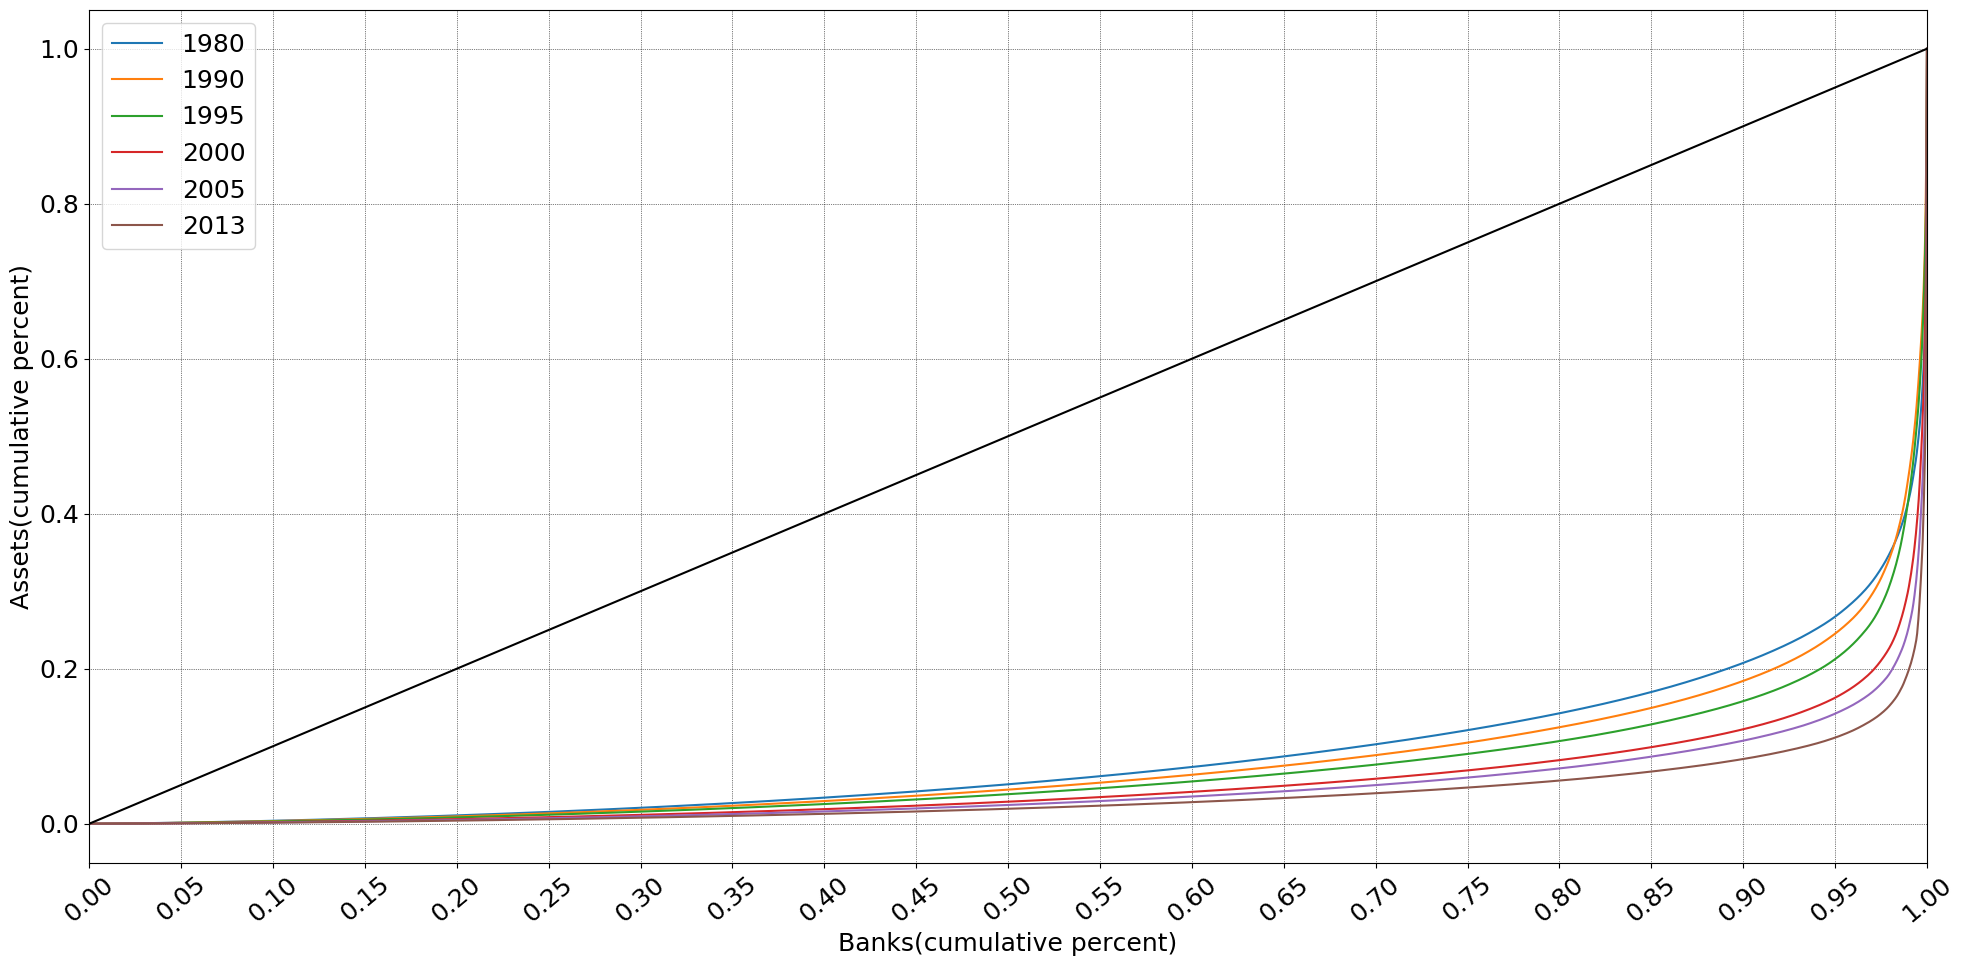

In [36]:
fig, ax = plt.subplots(figsize=figsize_OneGraph)

df_1980_1 = df_assets[(df_assets.year==1980) & (df_assets.quarter==1)]
df_1985_1 = df_assets[(df_assets.year==1985) & (df_assets.quarter==1)]
df_1990_1 = df_assets[(df_assets.year==1990) & (df_assets.quarter==1)]
df_1995_1 = df_assets[(df_assets.year==1995) & (df_assets.quarter==1)]
df_2000_1 = df_assets[(df_assets.year==2000) & (df_assets.quarter==1)]
df_2005_1 = df_assets[(df_assets.year==2005) & (df_assets.quarter==1)]
df_2013_1 = df_assets[(df_assets.year==2013) & (df_assets.quarter==1)]

lorenz_curve(df_1980_1.assets.values, ax)
#lorenz_curve(df_1985_1.assets.values, ax)
lorenz_curve(df_1990_1.assets.values, ax)
lorenz_curve(df_1995_1.assets.values, ax)
lorenz_curve(df_2000_1.assets.values, ax)
lorenz_curve(df_2005_1.assets.values, ax)
lorenz_curve(df_2013_1.assets.values, ax)

ax.plot([0,1], [0,1], color='k')

ax.legend(["1980", "1990", "1995", "2000", "2005", "2013"])
ax.grid()
ax.set_ylabel("Assets(cumulative percent)")
ax.set_xlabel("Banks(cumulative percent)")

plt.tight_layout()

plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_LorenzCurve_7613.png')


Gini Coefficient

In [37]:
'''
Function to compute gini coefficient for a given array of asset values
'''
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

In [38]:
'''
Computes for every year and month the gini coefficient
'''
def comp_gini(gr):
    #gr.dropna(subset=["assets"], inplace=True, axis=0)
    coef = gini(gr.assets.values)
    gr = gr.sum()
    gr["gini"] = coef
    return gr

df_assets_copy = df_assets.copy()
df_assets_copy.dropna(subset=["assets"], inplace=True)
df_assets_gini = df_assets_copy.groupby("date").apply(comp_gini)

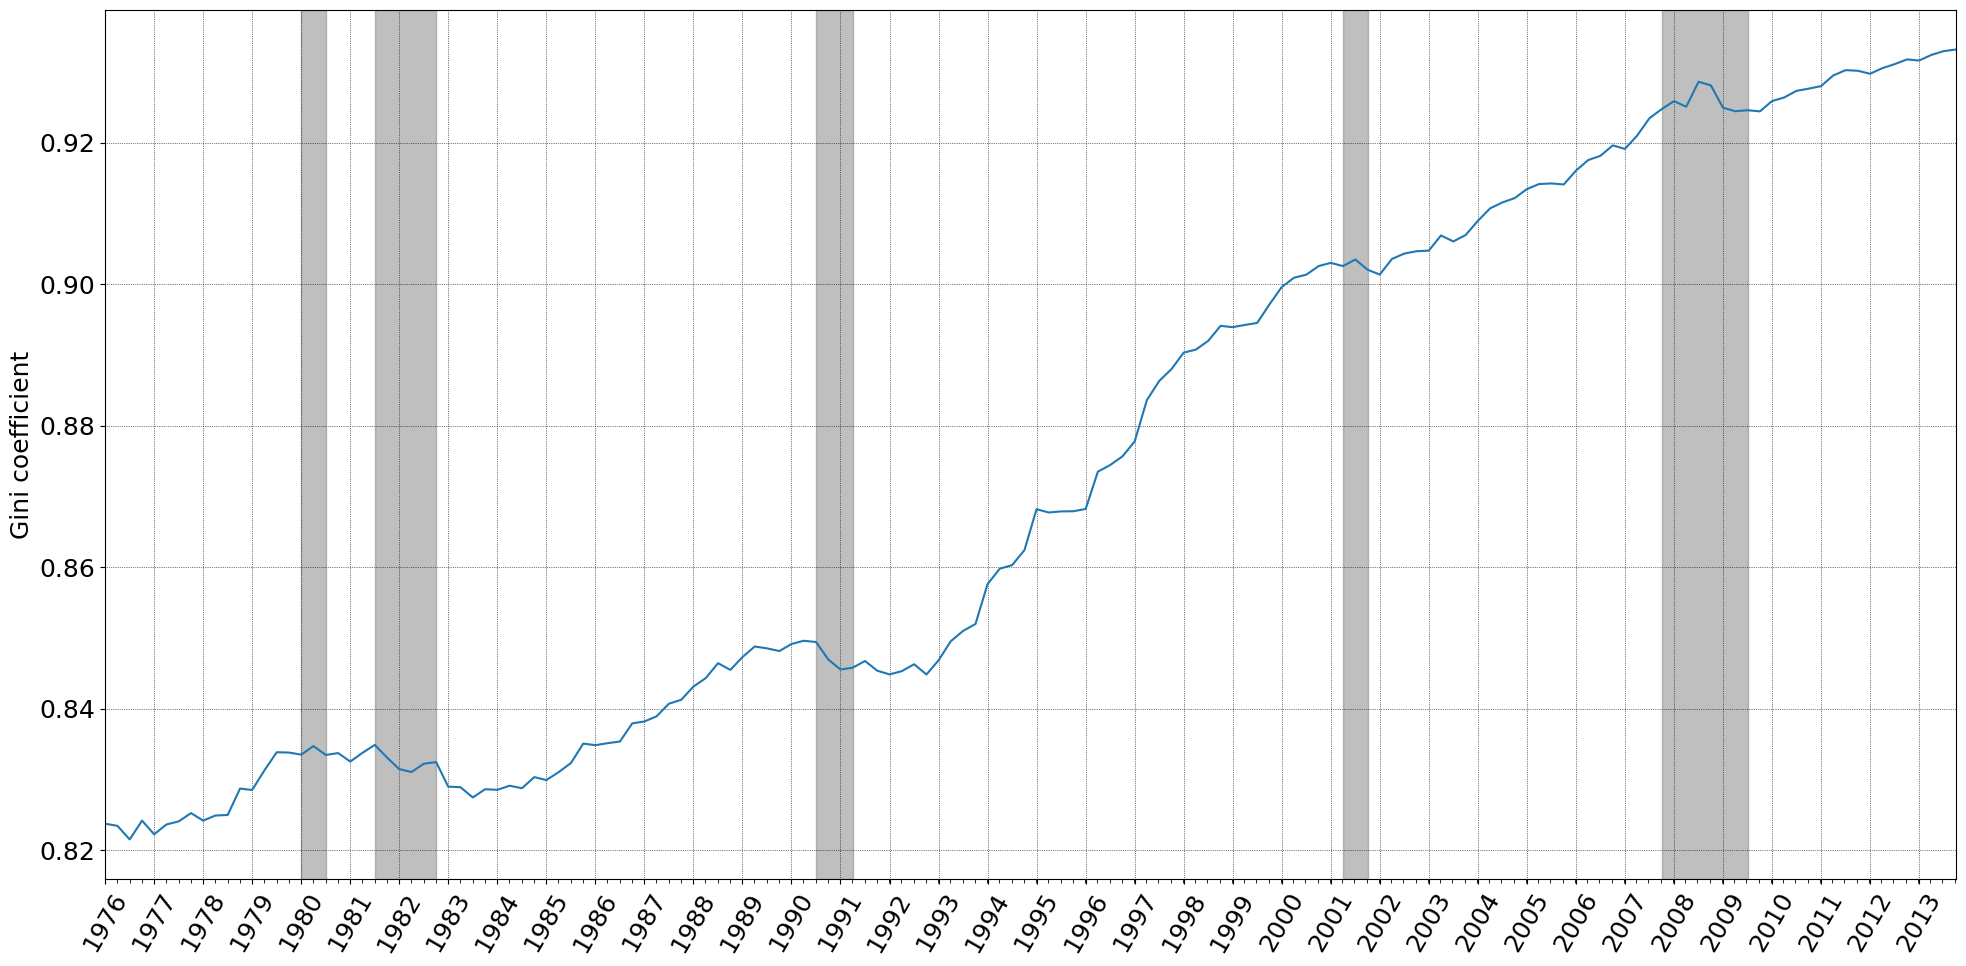

In [39]:
#plot gini coefficient with xaxis as datetime objects


fig, ax = plt.subplots(figsize=figsize_OneGraph)

year_locator = mlt.dates.YearLocator(1, month=3, day=31)
years_fmt = mlt.dates.DateFormatter('%Y')

ax.plot(df_assets_gini.gini)

ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=60)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylabel("Gini coefficient")
ax.grid()
ax.set_xlim(datetime.datetime(1976,3,31), datetime.datetime(2013,12,31))
        
plot_crisis_datetime(ax)

plt.tight_layout()
plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_gini_7613.png')

In [40]:
#alternative way to compute gini coefficient per year with loop
array = []

for year in years:
    
    temp = df_assets[(df_assets.year==float(year))]
    temp.dropna(subset=["assets"], inplace=True)
    #print(temp.assets.isna().value_counts())
    array.append(gini(temp.assets.values))


s_gini_coeff = pd.Series(array, index=years)



Banks by asset categories